<a href="https://colab.research.google.com/github/martynas2514/A-B-tests/blob/main/A_B_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B tests 

A/B testing is a shorthand for a simple randomized controlled experiment, in which two samples (A and B) of a single vector-variable are compared.[1] These values are similar except for one variation which might affect a user's behavior. A/B tests are widely considered the simplest form of controlled experiment.

Version A might be a version used at present (thus forming the control group), while version B is modified in some respect vs. A (thus forming the treatment group). For instance, on an e-commerce website the purchase funnel is typically a good candidate for A/B testing, since even marginal-decreases in drop-off rates can represent a significant gain in sales. Significant improvements can be sometimes seen through testing elements like copy text, layouts, images and colors, but not always. In these tests, users only see one of two versions, since the goal is to discover which of the two versions is preferable.

source: https://en.wikipedia.org/wiki/A/B_testing

## Data set 

for this project kaggle dataset will be used: https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing?resource=download

In [ ]:
import pandas as pd 

df = pd.read_csv("../content/marketing_AB.csv",index_col=0)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


lets fix dtypes 

In [ ]:
df[["user id","most ads day","test group"]] = df[["user id","most ads day","test group"]].astype("category")
df.dtypes

## data analysis

user id - User ID (unique) 




In [ ]:
df["user id"].value_counts()


900000     1
1427238    1
1427232    1
1427233    1
1427234    1
          ..
1199964    1
1199963    1
1199962    1
1199961    1
1654483    1
Name: user id, Length: 588101, dtype: int64

test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement

In [ ]:
df["test group"].value_counts()

ad     564577
psa     23524
Name: test group, dtype: int64

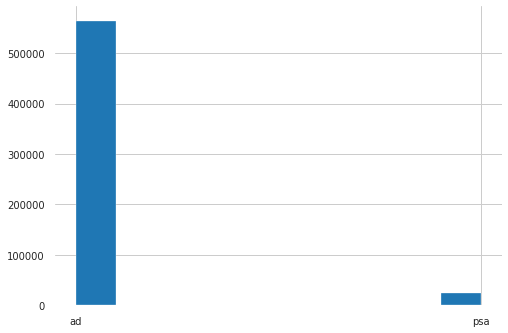

In [ ]:
df["test group"].hist()

converted: If a person bought the product then True, else is False

In [ ]:
df["converted"].value_counts()

False    573258
True      14843
Name: converted, dtype: int64

total ads: Amount of ads seen by person

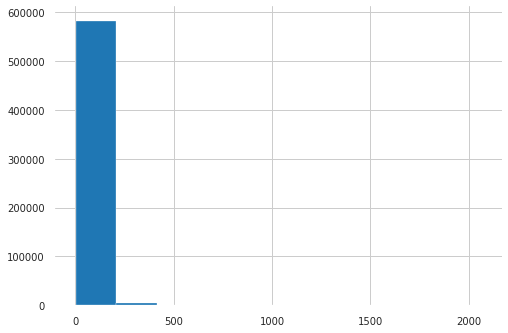

In [ ]:
df["total ads"].hist()

In [ ]:
df["total ads"].describe()

count    588101.000000
mean         24.820876
std          43.715181
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000
Name: total ads, dtype: float64

most ads day: Day that the person saw the biggest amount of ads

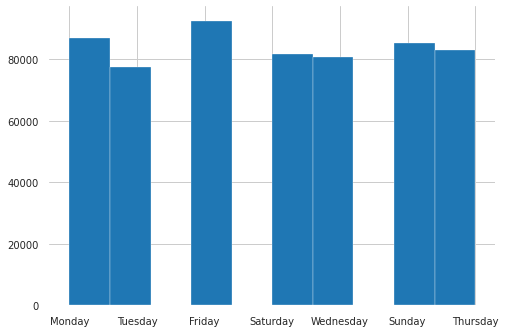

In [ ]:
df["most ads day"].hist()

In [ ]:
df["most ads day"].value_counts()

Friday       92608
Monday       87073
Sunday       85391
Thursday     82982
Saturday     81660
Wednesday    80908
Tuesday      77479
Name: most ads day, dtype: int64

most ads hour: Hour of day that the person saw the biggest amount of ads

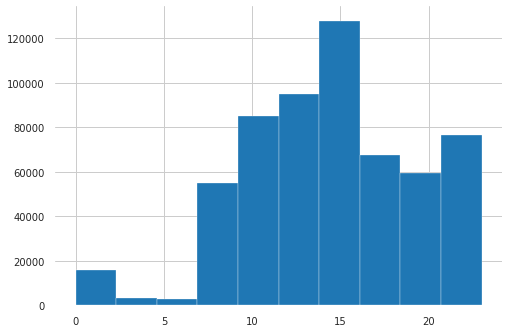

In [ ]:
df["most ads hour"].hist()

# tests for other feature independence

now we will test if distributions of total ads, most ads day, most ads hour are the same for both groups.

## total ads 

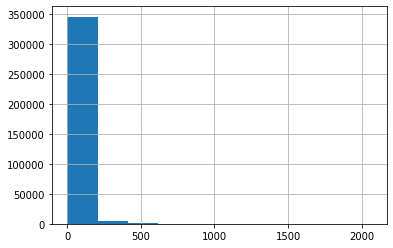

In [51]:
import numpy as np
df[df["test group"] == "ad"]["total ads"].hist()

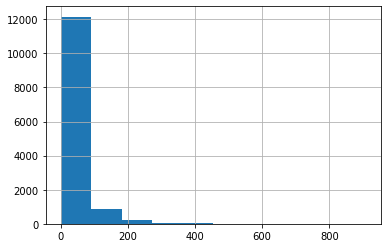

In [52]:
df[df["test group"] == "psa"]["total ads"].hist()

data is distributed approximately as a exponential distribution. To check if distributions are the same, we will do a hypothesis testing. 

Proper test must be chosen: 

because data is not normal non-parametric test will be used. in this case mann-whitney U test.

for different test assumptions check https://ai-master.gitbooks.io/hypothesis-testing/content/different-types-of-hypothesis-testing.html

we will assume the alpha = 0.05



In [56]:
from scipy.stats import mannwhitneyu

In [58]:
mannwhitneyu(df[df["test group"] == "ad"]["total ads"], df[df["test group"] == "psa"]["total ads"])

MannwhitneyuResult(statistic=2297947653.0, pvalue=0.00012134271298543769)

because pvalue < 0.05 we reject null hypothesis that distributions are the same 

## most ads day 

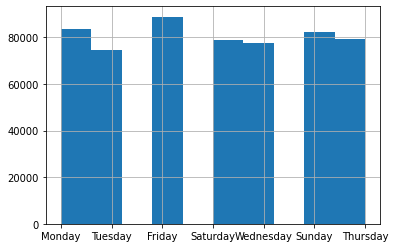

In [ ]:
df[df["test group"] == "ad"]["most ads day"].hist()

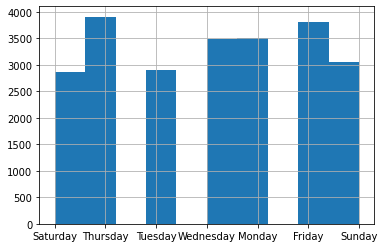

In [ ]:
df[df["test group"] == "psa"]["most ads day"].hist()

most ads day are categorical data, to estimate if distributions are the same we will use chi2 test of independence.

https://online.stat.psu.edu/stat200/book/export/html/230#:~:text=The%20chi-square%20%28%20%CF%87%202%29%20test%20of%20independence,%28%20A%29%20%3D%20P%20%28%20A%20%E2%88%A3%20B%29.

H_0: test group and most ads day are independent (distributions are same);

H_a: test group and most ads day are dependent (distributions differ);

alpha = 0.05

In [ ]:
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(df["test group"], df["most ads day"])
chi2_contingency(crosstab)

(376.50455427620653,
 3.1342900966485243e-78,
 6,
 array([[57909.91236445, 53871.27667542, 48612.95759366, 49273.86028514,
         47404.83518096, 47235.27414058, 46876.88375978],
        [ 2199.08763555,  2045.72332458,  1846.04240634,  1871.13971486,
          1800.16481904,  1793.72585942,  1780.11624022]]))

because 3.1342900966485243e-78 < 0.05, we reject null hypothesis, as a result we say that test group and most ads day are dependent (distributions differ);

## most ads hour 

In [ ]:
from scipy.stats import boxcox
from matplotlib.pyplot import hist 
from scipy.stats import ttest_ind

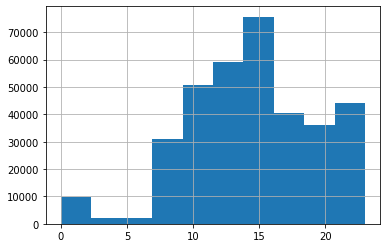

In [ ]:
df[df["test group"] == "ad"]["most ads hour"].dropna().hist()


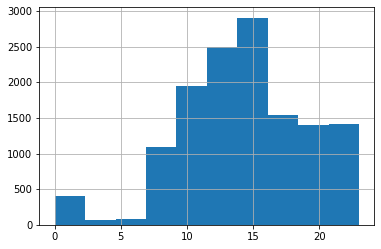

In [ ]:
df[df["test group"] == "psa"]["most ads hour"].hist()

In [ ]:
ttest_ind(df[df["test group"] == "ad"]["most ads hour"].dropna(), df[df["test group"] == "psa"]["most ads hour"].dropna(), axis=0, equal_var=False)

Ttest_indResult(statistic=4.000866212444353, pvalue=6.34265022068416e-05)

pvalue < 0.05, means are different

## test if  ads improved sales 

because values are binary, 2 sample proportion z test will be performed:

H_0 p1 = p2
H_a p1 < p2

this is left tail test 

In [ ]:
pd.crosstab(df["test group"], df["converted"])

converted,False,True
test group,,
ad,338717,12468
psa,13007,329


In [ ]:
df["test group"].value_counts()

ad     351186
psa     13336
Name: test group, dtype: int64

In [ ]:
p1 = 329/13336
p2 = 12468/351186
p = (329+12468) / (13336 + 351186)
n1 = 13336
n2 = 351186

z = (p1 - p2)/np.sqrt(p*(1-p)*((1/n1)+(1/n2)))


In [ ]:
import scipy.stats as stats
print(stats.norm.cdf(z))

1.2670316186380623e-11


1.2670316186380623e-11 < 0.05, reject null hypothesis. 
ads improved sales 

# conclusions 

2 sample proportion z test shown that ads increased convertion rate. However assumption that data should be sampled independently is not valid. as it can be seen from statistical tests: total ads, most ads day, most ads hour are dependent on test groups.